# Tau and Dimension Optimization

## RIPS AFRL 2020

## Version August 19, 2020

Here we implement the AMI method, show visualizations of the shadow manifold vs. Tau, and implement Cao's method.

In [6]:
from sklearn.neighbors import KDTree
import numpy as np

import sys
import os
import time

In [7]:
X = np.load(os.path.join("..", "data", "anode_cathode.npy"))

# Using Average Mutual Information (AMI) for Guessing Optimal Tau

In [3]:
lags = range(0, 300, 2)
n = len(X)
x = (X - min(X))/(max(X)-min(X))

amis = []

for lag in lags:
    ami = 0.0

    nbins = int(np.floor(1 + np.log2(n - lag) + 0.5))
    
    pij = np.zeros((nbins, nbins))
    pi = np.zeros((nbins,))
    pj = np.zeros((nbins,))
    
    x2 = np.floor(x*nbins).astype(int)
    for i in range(len(x2)):
        if x2[i] == nbins:
            x2[i] -= 1
    
    for i in range(len(x)-lag):
        pij[x2[i], x2[i+lag]] += 1
        pi[x2[i]] += 1
        pj[x2[i+lag]] += 1
    
    pij /= len(x)-lag
    pi /= len(x)-lag
    pj /= len(x)-lag
    
    for i in range(nbins):
        for j in range(nbins):
            if pij[i, j] > 0:
                ami += pij[i, j] * np.log2(pij[i, j] / (pi[i] * pj[j]))
    
    amis.append(ami)

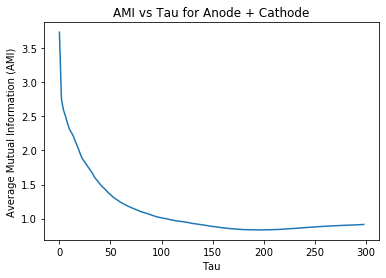

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(facecolor='w')
plt.plot(lags, amis)

ax.set_xlabel("Tau")
ax.set_ylabel("Average Mutual Information (AMI)")
ax.set_title("AMI vs Tau for Anode + Cathode")

plt.show()

# Visualizing Different Taus

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


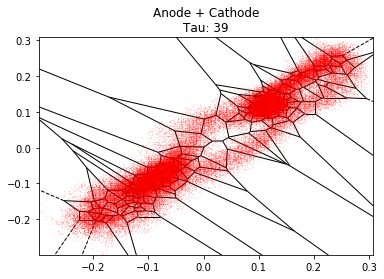

In [5]:
data = X.reshape((len(X), 1))

# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc

rc('animation', html='html5')

# for voronoi
from scipy.spatial import Voronoi, voronoi_plot_2d

total = 100000

fig, ax = plt.subplots()
ydata = []
ln, = plt.plot([], [], 'ro', markersize=0.05)

def init():
    ax.set_xlim(min(data), max(data))
    ax.set_ylim(min(data), max(data))
    return ln,

sample_idxs = np.random.choice(range(total), size=200, replace=False)

def update(frame):
    print(frame)
    ax.clear()
    
    # Voronoi
    size = 10
    shadow = np.concatenate((data[:total], data[frame:total+frame]), axis=1)
    sample = shadow[sample_idxs]
    vor = Voronoi(sample)
    fig = voronoi_plot_2d(vor, show_vertices=False, show_points=False, ax=ax)
    ax.plot(*zip(*shadow), 'ro', markersize=0.05)
    
    ax.set_xlim(min(data), max(data))
    ax.set_ylim(min(data), max(data))

    ax.set_title("Anode + Cathode\nTau: "+str(frame))
    return ln,

# note: can't start range at 0
ani = animation.FuncAnimation(fig, update, frames=range(1, 40, 1),
                    init_func=init, 
# this adjusts the speed
#                     interval=100,
                    blit=True)
ani

# Cao's Method

In [6]:
# tau of choice, perhaps from the method above
tau = 150

In [7]:
max_d = 25

In [8]:
l = []
total = len(data) - (max_d-1)*tau
for i in range(max_d):
    l.append(X[i*tau:total+i*tau].reshape((total, 1)))
shadow = np.concatenate(tuple(l), axis=1)

In [9]:
from scipy.spatial import cKDTree

e = []
estar = []

dims = range(1, max_d-1)

for d in dims:
    print(d)
    
    kdt = cKDTree(shadow[:,:d])
    neighbors = kdt.query(shadow[:,:d], k=2)[1][:,1]
    
    closest = shadow[neighbors]

    tes = abs(shadow[:,1:d+1] - closest[:,1:d+1]).max(axis=1) / abs(shadow[:,:d] - closest[:,:d]).max(axis=1)
    
    e.append(np.ma.masked_invalid(tes).mean())
    
    estar.append(abs(shadow[:,d+1] - closest[:,d+1]).mean())

1


/home/atkirtland/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/atkirtland/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [10]:
e1 = []
e2 = []
for i in range(1, len(e)):
    e1.append(e[i] / e[i-1])
    e2.append(estar[i] / estar[i-1])

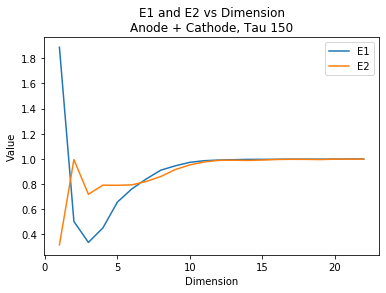

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(facecolor='w')
plt.plot(dims[0:-1], e1)
plt.plot(dims[0:-1], e2)

ax.set_xlabel("Dimension")
ax.set_ylabel("Value")
ax.set_title("E1 and E2 vs Dimension\nAnode + Cathode, Tau "+str(tau))

ax.legend(["E1", "E2"])

plt.show()